In [2]:

import torch #Pytorch
import matplotlib as plt #Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns #Seaborn
import numpy as np
import pandas as pd
import math as math
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split # Splits data into training/testing sets
from sklearn.preprocessing import StandardScaler #scales data for better preformance

df = pd.read_csv('EditedCSVs/df2CSV.csv')

In [3]:
display(df)

,Sex,NOC,Year,City,Sport,Event,Medal
0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,0
2,0,1,2,2,2,2,0
3,0,1,3,3,3,3,1
4,1,2,4,4,4,4,0
...,...,...,...,...,...,...,...
252560,1,188,30,3,4,711,0
252561,1,13,30,3,12,953,0
252562,0,2,30,3,4,846,1
252563,0,7,30,3,62,787,2


In [4]:
df1 = df.drop(["Medal"],axis=1)
a = df1.to_numpy()
print(a)

[[  0   0   0   0   0   0]
 [  0   0   1   1   1   1]
 [  0   1   2   2   2   2]
 ...
 [  0   2  30   3   4 846]
 [  0   7  30   3  62 787]
 [  0  84  30   3   4 950]]


In [5]:
device = (
    "CPU"
)
print(f"Using {device} device")

Using CPU device


In [6]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10,20)
        self.fc3 = nn.Linear(20,15)
        self.fc4 = nn.Linear(15, output_size+1)  # 20 extra for safety     
        self.drp = nn.Dropout(p=0.1,inplace=False)
       
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.drp(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.drp(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.drp(x)
        x = self.fc4(x)
        return x

In [7]:
def trainSplit(X,y):
    scalar = StandardScaler()


    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

    X_train = scalar.fit_transform(X_train)
    X_test = scalar.transform(X_test)


    #converts to pytorch tensors and moves them to the device we selected


    X_train_tensor = (torch.tensor(X_train,dtype=torch.float32))
    X_test_tensor = (torch.tensor(X_test,dtype=torch.float32))

    y_train_tensor = (torch.tensor(y_train,dtype=torch.long))
    y_test_tensor = (torch.tensor(y_test,dtype=torch.long))

    return X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor

In [24]:
def train(X_train_tensor,y_train_tensor,model,filename=None,num_epocs=None):

    #Default num_epocs if none are specified
    if num_epocs is None:
        num_epocs = 50        

    #Loss function and optimizer
    lossF = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=0.01)

    for epoch in range(num_epocs):
        outputs = model(X_train_tensor)
        loss = lossF(outputs,y_train_tensor)

        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        if(epoch+1)%10 == 0:
            print(epoch+1)
    #Save the model if a file name is given
    if filename is not None:
        torch.save(model,filename)
        print(f'Saved model as: {filename}')
    

In [26]:
y = df["Medal"].to_numpy()

inputSize = a[0].size
outputSize = int(y.max())

xte,yte,xtest,ytest = trainSplit(a,y)
model = SimpleNeuralNetwork(inputSize,outputSize)
train(xte,yte,model,"Model",num_epocs=200)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Saved model as: Model


In [27]:
def printResults(model,X_test_tensor,y_test_tensor,error=None):
    if error is None:
        error = 100
    else:
        error = error/10
    with torch.no_grad():  
        outputs = model(X_test_tensor)  
        _, predicted = torch.max(outputs, 1) 

        # Calculate accuracy
        correct = (abs(predicted - y_test_tensor) < error).sum().item()  
        print(f'Correct: {correct}/{y_test_tensor.size(0)}')
        accuracy = correct / y_test_tensor.size(0)  
        print(f'Accuracy on test data: {accuracy * 100:.2f}%')

        predicted = predicted.cpu()
        y_test_tensor = y_test_tensor.cpu()
        predicted_values = (predicted.numpy())
        actual_values = (y_test_tensor.numpy())

        data = pd.DataFrame({
            'Actual': actual_values,
            'Predicted': predicted_values
        })

        fig, ax = plt.subplots(figsize=(10, 6))  


        ax.scatter(data['Actual'], data['Predicted'], alpha=0.6, label='Data points')


        ax.plot(
            [data['Actual'].min(), data['Actual'].max()],
            [data['Actual'].min(), data['Actual'].max()],
            color='red',
            label='Ideal fit'
        )


        ax.set_title('Actual vs Predicted Values') 
        ax.set_xlabel('Actual Values')  
        ax.set_ylabel('Predicted Values')  
        ax.legend()
        ax.grid(True)

    return ax

In [28]:
def loadModel(modelName):
    model = torch.load(modelName,weights_only=False)
    model.eval()
    return model

Correct: 0/50513
Accuracy on test data: 0.00%


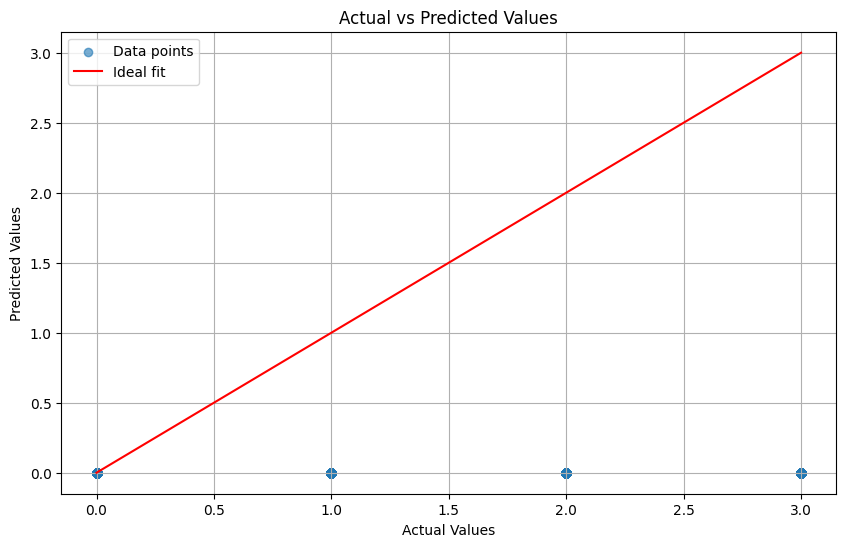

In [29]:
printResults(loadModel("Model"),xtest,ytest,error=0)
plt.show()

In [ ]:
d